In [164]:
import pandas as pd
import numpy as np
import sidetable
import matplotlib.pyplot as plt
import seaborn as sns
# Establecer tamaño fijo de gráficas
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

EJERCICIO 1: Buscar un conjunto de datos a analizar

In [165]:
df_original=pd.read_csv('../datos/ds_salaries.csv', index_col=0)
df_original.head(2) #Hacemos una vista previa de nuestro DataFrame

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S


Explicar los datos y las variables disponibles en el conjunto de datos seleccionado:

| work_year| The year the salary was paid |
|----------|------------------------------|
| experience_level| The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director|
| employment_type| The type of employement for the role: PT Part-time FT Full-time CT Contract FL Freelance|
| job_title| The role worked in during the year|
| salary| The total gross salary amount paid |
| salary_currency| The currency of the salary paid as an ISO 4217 currency code |
| salaryinusd| The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com) |
| employee_residence| Employee's primary country of residence in during the work year as an ISO 3166 country code |
| remote_ratio| The overall amount of work done remotely, possible values are as follows: 0 No remote work (less than 20%) 50 Partially remote 100 Fully remote (more than 80%) |
| company_location| The country of the employer's main office or contracting branch as an ISO 3166 country code |
| company_size| The average number of people that worked for the company during the year: S less than 50 employees (small) M 50 to 250 employees (medium) L more than 250 employees (large) |

Primero nos creamos una copia

In [166]:
df2=df_original.copy()

Nuestra hipótesis: Cuánto puede llegar a ganar un Data Scientist,Data Analyst,Business Data Analyst,Data Engineer.

### Vamos a filtrar nuestro DataFrame de acuerdo a nuestra hipótesis

Vamos a filtrar sólo por los puestos que nos interesan

In [167]:
df_filtrado=df_original[df_original["job_title"].isin(['Data Scientist','Data Analyst','Business Data Analyst','Data Engineer'])]

Ahora vamos a filtrar por los paises que sean más recurrentes en company_location (>= a 10)

In [168]:
df_c = df_filtrado.groupby('company_location').size().reset_index(name='paises').sort_values(by = 'paises', ascending=False) 
#Miramos cuales son los paises que más aparecen
df_c

,company_location,paises
28,US,242
10,GB,36
3,CA,15
14,IN,12
6,DE,12
9,FR,11
8,ES,10
11,GR,8
0,AT,3
26,TR,3


In [169]:
df=df_filtrado[df_filtrado["company_location"].isin(["US","GB","CA","IN","DE","FR","ES"])] #Filtramos por los paises que aparezcan >= a 10

In [170]:
df.groupby('employment_type').size()

employment_type
CT      1
FL      2
FT    333
PT      2
dtype: int64

In [171]:
df[df['employment_type'].isin(['CT','FL','PT'])] # Miramos si hay alguna categoria de job_title que nos esté generando estas frecuencias tan bajas en employment_type

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
28,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L
124,2021,EN,PT,Data Analyst,8760,EUR,10354,ES,50,ES,M
208,2021,MI,FL,Data Engineer,20000,USD,20000,IT,0,US,L
462,2022,MI,PT,Data Engineer,50000,EUR,54957,DE,50,DE,L
488,2022,MI,FL,Data Scientist,100000,USD,100000,CA,100,US,M


Como vemos arriba, tenemos categorias en la variable de employment_time que solo acumulan 1 o 2 de frecuencia, la cual cosa, no supone una muestra significativa para poder desarrollar nuestro modelo. De esta forma, decidimos quedarnos con solo los employment_type de full time.

In [172]:
df = df[df['employment_type'] == 'FT']

In [173]:
df['employment_type'].unique()

array(['FT'], dtype=object)

In [174]:
df.groupby('employee_residence').size()

employee_residence
BG      1
BR      1
CA     15
DE      8
ES     10
FR     11
GB     34
GR      1
HK      1
IN     13
PH      1
PK      2
RO      2
RS      1
RU      1
US    231
dtype: int64

Filtramos sólo por los países con un tamaño >= a 10

Como en el caso anterior, también en employee_residence vemos que tenemos muestras inferiores a 10 personas por categoria. Esto no es suficientemente significativo para construir el modelo predictivo, por lo que decidimos filtrar nuestros datos para aquellas categorias qeu acumulen una frecuencia igual o superior a 10.

In [175]:
df = df[df['employee_residence'].isin(['CA','ES','FR','GB','IN','US'])]

In [176]:
df['employee_residence'].unique()

array(['US', 'FR', 'IN', 'GB', 'ES', 'CA'], dtype=object)

Listo! Tenemos nuestro DataFrame filtrado.

In [177]:
df.head(2)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L
8,2020,MI,FT,Business Data Analyst,135000,USD,135000,US,100,US,L


### Ejercicio 2

- Realizar un EDA sencillo para la variable dependiente y la variable independiente.

Nuestra variable respuesta será la de salary_in_usd y las demás serán las predictoras.
De esta manera, ya podemos eliminar columnas que no vamos a necesitar en nuestro estudio y a renombrar categorias para entender mejor nuestro análisis.

Renombramos las etiquetas de experience level y employment type para entenderlo mejor

In [178]:
df['experience_level'].replace({'EN':'Entry-Level','MI':'Mid-Level','EX':'Executive Level','SE':'Senior'},inplace=True)
df['employment_type'].replace({'FT':'Full-Time'},inplace=True)

Eliminamos las columnas que no vamos a utilizar en el DF: salary y salary_currency

In [179]:
df.drop(['salary','salary_currency'], axis =1, inplace= True)

In [180]:
#Vamos a ver la forma de nuestro DataFrame.
print(f'Tenemos {df.shape[0]} filas y {df.shape[1]} columnas')

Tenemos 314 filas y 9 columnas


Miramos cuantos nulos tenemos

In [181]:
df.stb.missing()

,missing,total,percent
work_year,0,314,0.0
experience_level,0,314,0.0
employment_type,0,314,0.0
job_title,0,314,0.0
salary_in_usd,0,314,0.0
employee_residence,0,314,0.0
remote_ratio,0,314,0.0
company_location,0,314,0.0
company_size,0,314,0.0


0 nulos!! Genial!!

Vamos a ver los tipos de datos de nuestras columnas.

In [182]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

Genial! Al parecer todas nuestras columnas están con el tipo de dato correcto

Vamos a sacar los principales estadisticos para nuestras columnas numericas.

In [183]:
numericas = df.select_dtypes(include=['int64', 'float64'])
numericas.describe(include='number')

,work_year,salary_in_usd,remote_ratio
count,314.000000,314.000000,314.000000
mean,2021.636943,116024.305732,72.133758
std,0.620758,54746.097413,42.811362
min,2020.000000,5679.000000,0.000000
25%,2021.000000,78526.000000,50.000000
50%,2022.000000,112436.000000,100.000000
75%,2022.000000,149250.000000,100.000000
max,2022.000000,412000.000000,100.000000


Vemos que nuestros datos son de los últimos 2 años, que la media del año es 2021 y que nuestros datos de salario se ven afectados por un posible outlayer, el cual se puede observar en el valor máximo.

Vamos a ver los outlayers graficamente

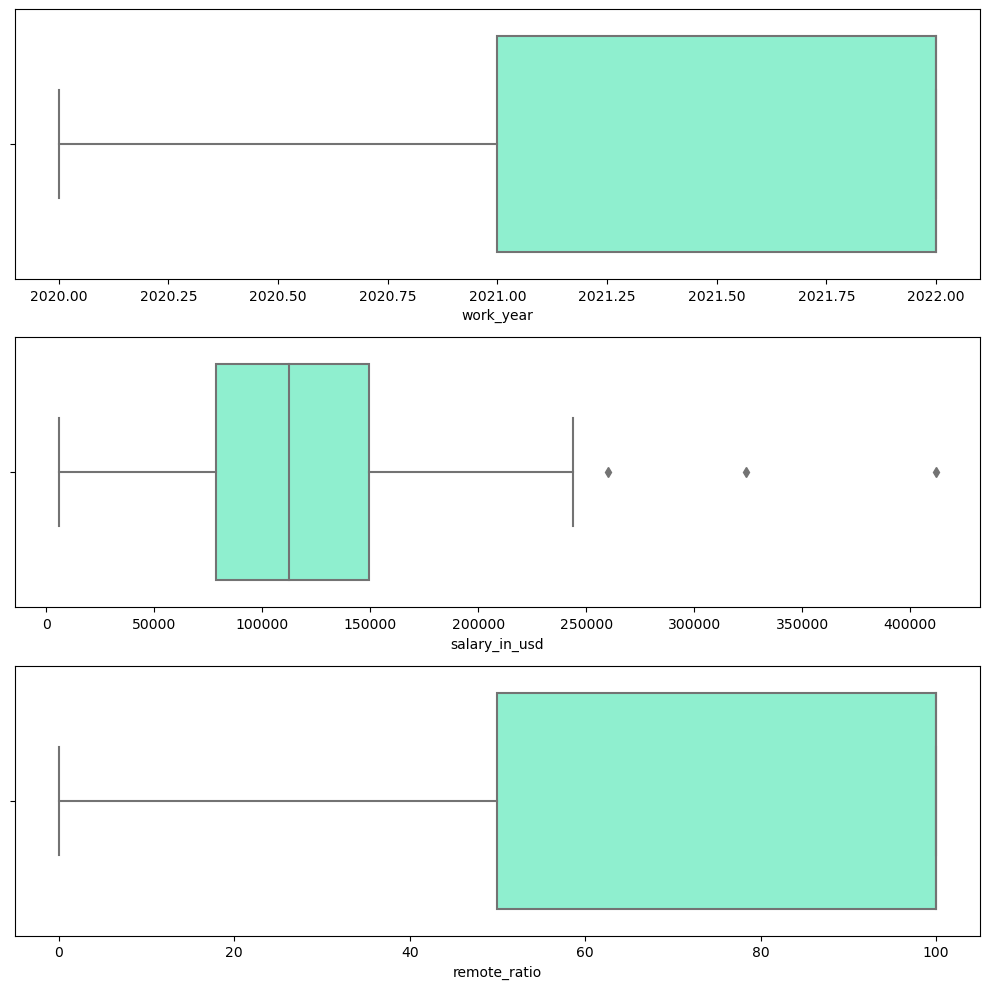

In [184]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = numericas, ax=axes[indice], color = "aquamarine"); # para trazar una línea de densidad
  
plt.tight_layout()
plt.show()

Efectivamente, como sospechabamos, tenemos outliers a partir de un poquito más de 250000 dólares de salario (aproximadamente).

Qué hacemos con estos outliers? Vamos a estudiarlos en dos df separados y averiguamos el por qué de estos outliers, o si simplemente son un error de muestreo. 
Partiremos nuestro df de salarios bajos en 2 por el Q3.

In [185]:
def detectar_outliers(lista_columnas, dataframe): 
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_bajos = dataframe[(dataframe[col] > Q3 + outlier_step)]

    
    return outliers_bajos

In [186]:
salarios_altos = detectar_outliers(['salary_in_usd'],df)
salarios_altos.head(2)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
63,2020,Senior,Full-Time,Data Scientist,412000,US,100,US,L
416,2022,Senior,Full-Time,Data Scientist,260000,US,100,US,M


In [187]:
salarios_altos['salary_in_usd'].min()

260000

Hemos creado un DF con los outliers, y sabemos a partir de qué salario lo considera outlier. Vamos a filtrar el df de salarios_bajos para que no contentga outliers

In [188]:
salarios_bajos = df[df['salary_in_usd']< 260000]
salarios_bajos.head(2)


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
5,2020,Entry-Level,Full-Time,Data Analyst,72000,US,100,US,L
8,2020,Mid-Level,Full-Time,Business Data Analyst,135000,US,100,US,L


Vamos a comparar variables como las de job title, experience, employment type, company location y company size para ver si hay alguna diferencia entre mis dos nuevos subdataframes del salario bajo, para entender el tratamiento de los outliers

In [189]:
salarios_altos.groupby('experience_level').size()

experience_level
Executive Level    1
Senior             2
dtype: int64

In [190]:
salarios_bajos.groupby('experience_level').size()

experience_level
Entry-Level         32
Executive Level      5
Mid-Level          107
Senior             167
dtype: int64

In [191]:
salarios_altos.groupby('job_title').size()

job_title
Data Engineer     1
Data Scientist    2
dtype: int64

In [192]:
salarios_bajos.groupby('job_title').size()

job_title
Business Data Analyst      3
Data Analyst              89
Data Engineer            108
Data Scientist           111
dtype: int64

In [193]:
salarios_altos.groupby('employment_type').size()

employment_type
Full-Time    3
dtype: int64

In [194]:
salarios_bajos.groupby('employment_type').size()

employment_type
Full-Time    311
dtype: int64

In [195]:
salarios_altos.groupby('company_location').size()

company_location
US    3
dtype: int64

In [196]:
salarios_bajos.groupby('company_location').size()

company_location
CA     15
ES      9
FR     11
GB     34
IN     12
US    230
dtype: int64

In [197]:
salarios_altos.groupby('company_size').size()

company_size
L    1
M    2
dtype: int64

In [198]:
salarios_bajos.groupby('company_size').size()

company_size
L     71
M    222
S     18
dtype: int64

Como hemos visto con este análisis, podemos intuir que los outliers se deben a la diferencia entre tamaño de empresa, como un posible factor de variabilidad del precio. De esta manera, decidimos dividir nuestro DF en dos, para estudiarlo en casos separados.

Ahora para nuestras variables categoricas

In [199]:
df.describe(include='object')

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,314,314,314,314,314,314
unique,4,1,4,6,6,3
top,Senior,Full-Time,Data Scientist,US,US,M
freq,169,314,113,231,233,224


Podemos ver que la moda es Data Scientist, que se paga en dólares y que residen que USA,y trabajan en empresas medianas.

guardamos los dos data frames en dos archivos distintos:

In [200]:
salarios_bajos.to_csv('../datos/salarios_bajos.csv')

In [201]:
salarios_altos.to_csv('../datos/salarios_altos.csv')